## Немного об апроксимации
Из-за бутылочного горлышка в автокодировщиках, мы теряем часть информации. 
У нас всегда есть трейд-офф - какую часть информации мы готовы потерять при снижении размерности. Что нам важнее - мало факторов или снижение информации. Чем меньше будет факторов в латентном пространстве - тем более средние величины мы будем восстанавливать.

Чем больше размерность кодов, тем больше вариаций в данных автоэнкодер сможет передать. Если размерность кодов слишком мала, автоэнкодер запомнит нечто среднее по недостающим вариациям в заданной метрике (это одна из причин, почему mnist цифры все более размытые при снижении размерности кода в автоэнкодерах).



## Manifold hypothesis

Гипотеза о многообразие гласит, что многомерны данные из реального мира (например, изображения) лежат на многообразиях низкой размерности, вложенных в пространство большой размерности.

Более подробно на эту тему написано в [статье](https://bjlkeng.github.io/posts/manifolds/).

Здесь я приведу небольшую цитату из нее:\
*The main idea here is that even though our real-world data is high-dimensional, there is actually some lower-dimensional representation. For example, all "cat images" might lie on a lower-dimensional manifold compared to say their original 256x256x3 image dimensions. This makes sense because we are empirically able to the learn these things in a capacity limited neural network. Otherwise learning an arbitrary 256x256x3 function would be intractable*

Семинарский ноутбук составлен на основе другой [статьи](https://habr.com/ru/post/331500/)

In [1]:
 # Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Создание датасета
x1 = np.linspace(-2.2, 2.2, 1000)
fx = np.cos(x1)+np.sin(x1-3)
dots = np.vstack([x1, fx]).T
noise = 0.06 * np.random.randn(*dots.shape)
dots += noise

# Цветные точки для отдельной визуализации позже
from itertools import cycle
size = 25
colors = ["r", "g", "c", "y", "m"]
idxs = range(0, x1.shape[0], x1.shape[0]//size)
vx1 = x1[idxs]
vdots = dots[idxs]

In [2]:
len(x1), len(fx), np.vstack([x1, fx]).T.shape, noise.shape, len(idxs)

(1000, 1000, (1000, 2), (1000, 2), 25)

In [3]:
dots.shape

(1000, 2)

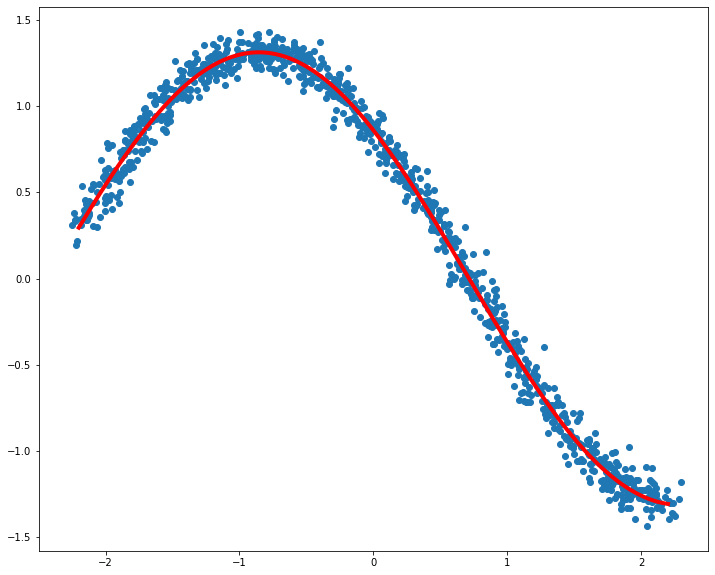

In [4]:
# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1])
plt.plot(x1, fx,  color="red", linewidth=4)
plt.grid(False)

Перепишем наш автоэнкодер под новые данные

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import tqdm

In [6]:
class PcaAutoencoder(nn.Module):

    def __init__(self, inp_shape, code_size=1):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()

        self.encoder = nn.Linear(inp_shape, code_size)
        self.decoder = nn.Linear(code_size, inp_shape)

    def forward(self, x):
        init_shape = x.shape
        x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        
        reconstruction = self.decoder(latent_code)
        reconstruction = reconstruction.reshape(init_shape)
        
        return reconstruction, latent_code

In [7]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EPOCHS = 40

cuda


In [8]:
# Train your autoencoder
def train(model, train_loader, device=DEVICE, epochs=EPOCHS, path=''):
    train_loss = []
    train_loss_epoch = []

    for epoch in tqdm(range(epochs)):
        model.train()
        for X in train_loader:
            batch = X[0].to(device)  # [0] is needed due to X being a list of one element because no y in (X, y) 
            reconstruction, _ = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            train_loss.append(loss.detach().cpu().numpy())
        
        train_loss_epoch.append(np.mean(train_loss))

        if epoch % 25 == 0:
            print(f"After {epoch} epochs, training loss: {train_loss_epoch[-1]:.6f}")

    return model, train_loss_epoch

In [9]:
input_shape = dots.shape[1]
input_shape

2

In [10]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = PcaAutoencoder(input_shape, code_size=1)
autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [11]:
X_train = torch.tensor(dots, dtype=torch.float32)
dataset_train = TensorDataset(X_train)

BATCH_SIZE = 32

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

**Важно:** `test_loader` нужен для того, чтобы при инференсе не перемешивать данные

In [12]:
model, train_loss = train(autoencoder, 
                          train_loader, 
                          device=DEVICE, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

After 0 epochs, training loss: 2.241986
After 25 epochs, training loss: 1.087732
After 50 epochs, training loss: 0.635159
After 75 epochs, training loss: 0.455628


**Важно:** на [StackOverflow](https://stackoverflow.com/questions/55533116/pca-inverse-transform-in-sklearn) приведено хорошее пояснение того, как из двухмерного облака точек получается одномерная линия вследтвие выполнения `pca.inverse_transform(pca.fit_transform(dots))`, т.е. что из себя представляют оранжевая и черная линии ниже

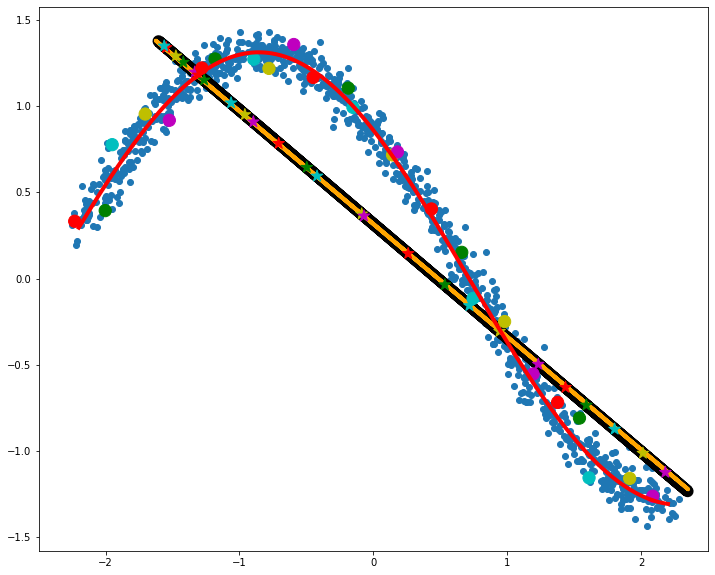

In [13]:
# Применение линейного автоэнкодера
res = []
with torch.no_grad():
    for X in test_loader:
        batch = X[0].to(DEVICE)  # [0] is needed due to X being a list
        reconstruction, _ = model(batch)
        reconstruction = reconstruction.cpu()
        res.append(reconstruction)
pdots = torch.cat(res)
vpdots = pdots[idxs]

# Применение PCA
from sklearn.decomposition import PCA
pca = PCA(1)
pdots_pca = pca.inverse_transform(pca.fit_transform(dots))

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots[:,0], pdots[:,1], color='black', linewidth=12, zorder=3)  # autoencoder
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)  # pca
plt.scatter(vpdots[:,0], vpdots[:,1], color=colors*5, marker='*', s=150, zorder=5)  # stars
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)  # colored circles on a blue cloud of dots
plt.grid(False)

Мы видим, что достаточно простое многообразие мы нашли. Добавим слоев.

In [14]:
class DeepAutoencoder(nn.Module):

    def __init__(self, inp_shape, code_size=1):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()

        self.encoder = nn.Sequential(nn.Linear(inp_shape, 64),
                                     nn.ELU(),
                                     nn.Linear(64, 64),
                                     nn.ELU(),
                                     nn.Linear(64, code_size))
        self.decoder = nn.Sequential(nn.Linear(code_size, 64),
                                     nn.ELU(),
                                     nn.Linear(64, 64),
                                     nn.ELU(),
                                     nn.Linear(64, inp_shape)
                                     )

    def forward(self, x):
        init_shape = x.shape
        x = torch.flatten(x, 1)
        latent_code = self.encoder(x)
        
        reconstruction = self.decoder(latent_code)
        reconstruction = reconstruction.reshape(init_shape)
        
        return reconstruction, latent_code

In [15]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

deep_autoencoder = DeepAutoencoder(input_shape, code_size=1)
deep_autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(deep_autoencoder.parameters(), lr=1e-3)

deep_model, train_loss = train(deep_autoencoder, 
                                train_loader, 
                                device=DEVICE, epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.350029
After 25 epochs, training loss: 0.020511
After 50 epochs, training loss: 0.011897
After 75 epochs, training loss: 0.008815


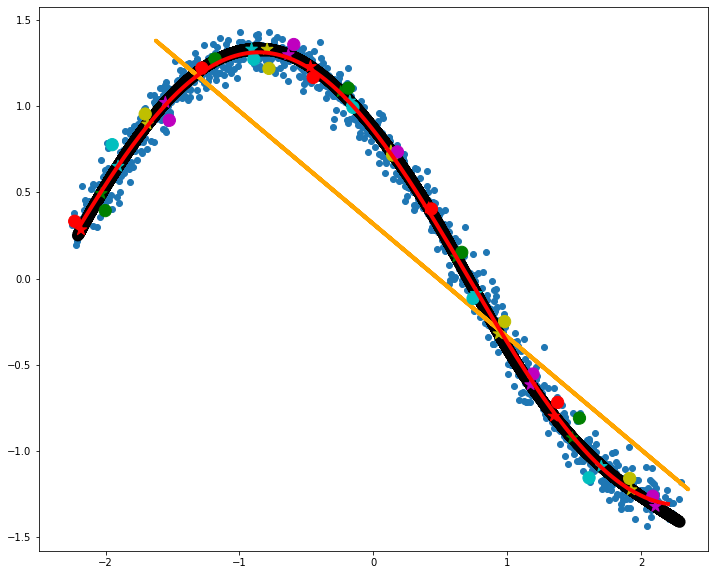

In [16]:
res = []
with torch.no_grad():
    for X in test_loader:
        batch = X[0].to(DEVICE)  # [0] is needed due to X being a list
        reconstruction, _ = deep_model(batch)
        reconstruction = reconstruction.cpu()
        res.append(reconstruction)
pdots_deep = torch.cat(res)
vpdots_deep = pdots_deep[idxs]

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots_deep[:,0], pdots_deep[:,1], color='black', linewidth=12, zorder=3)  # autoencoder
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)  # pca
plt.scatter(vpdots_deep[:,0], vpdots_deep[:,1], color=colors*5, marker='*', s=150, zorder=5)  # stars
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)  # colored circles on a blue cloud of dots
plt.grid(False)

У такого автоэнкодера практически идеально получилось построить определяющее многообразие: черная кривая почти совпадает с красной.

Глубокий автоэнкодер теоретически сможет найти многообразие произвольной сложности, например, такое, около которого лежат цифры в 784-мерном пространстве.


Все же у достаточно сложного автоэнкодера есть возможность переобучиться. Продемонстрируем это!
Мы берем и показываем одни и теже точки автоэнкодеру множество раз.

In [17]:
len(dots[idxs])

25

In [18]:
dots_oft = np.vstack([dots[idxs]]*4000)

X_train_oft = torch.tensor(dots_oft, dtype=torch.float32)
X_test_oft = torch.tensor(dots[idxs], dtype=torch.float32)  # важно: в тесте только выбранные точки без повторений
dataset_train_oft = TensorDataset(X_train_oft)
dataset_test_oft = TensorDataset(X_test_oft)

BATCH_SIZE = 32

train_loader_oft = DataLoader(dataset_train_oft, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_loader_oft = DataLoader(dataset_test_oft, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

In [19]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

deep_autoencoder = DeepAutoencoder(input_shape, code_size=1)
deep_autoencoder.to('cpu')

# Use Adam optimizer
optimizer = optim.Adam(deep_autoencoder.parameters(), lr=3e-4)

overfit_model, train_loss = train(deep_autoencoder, 
                                  train_loader_oft, 
                                  device='cpu', epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

After 0 epochs, training loss: 0.012570
After 25 epochs, training loss: 0.001599


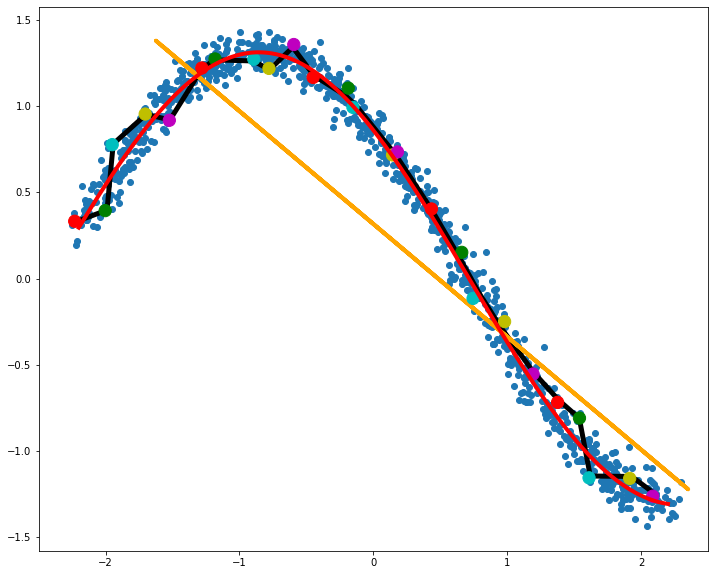

In [20]:
res = []
with torch.no_grad():
    for X in test_loader_oft:
        batch = X[0].to('cpu')  # [0] is needed due to X being a list
        reconstruction, _ = overfit_model(batch)
        res.append(reconstruction)
pdots_deep_oft = torch.cat(res)

# Визуализация
plt.figure(figsize=(12, 10))
plt.xlim([-2.5, 2.5])
plt.scatter(dots[:, 0], dots[:, 1], zorder=1)
plt.plot(x1, fx,  color="red", linewidth=4, zorder=10)
plt.plot(pdots_deep_oft[:, 0], pdots_deep_oft[:, 1], color='black', linewidth=5, zorder=3)
plt.plot(pdots_pca[:,0], pdots_pca[:,1], color='orange', linewidth=4, zorder=4)
plt.scatter(vdots[:,0], vdots[:,1], color=colors*5, s=150, zorder=6)
plt.grid(False)

Мы видим, что наша линия проходит через конкретные точки, и очень плохо описывает правильное многообразие.

В теории мы можем апроксимизировать какое угодно распределение.
Мы стремимся найти такое латентное пространство, 
где небольшие сдвиги в латентных переменных все равно остаются в том же классе.  

**Важная мысль:** если взять два объекта и посмотреть на объекты, лежащие на произвольной кривой между ними, то скорее всего промежуточные объекты не будут принадлежать генеральной совокупности, т. к. многообразие на котором лежит генеральная совокупность может быть сильно искривленным и малоразмерным.

In [21]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [22]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [23]:
train_data = train_data.data[:, None, :, :]
test_data = test_data.data[:, None, :, :]

X_train = torch.tensor(train_data, dtype=torch.float32)
X_test = torch.tensor(test_data, dtype=torch.float32)

dataset_train = TensorDataset(X_train)
dataset_test = TensorDataset(X_test)

loaders = {
    'train' : torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=256, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=256, 
                                          shuffle=False, 
                                          num_workers=1),
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [24]:
train_data.shape

torch.Size([60000, 1, 28, 28])

In [25]:
# Сверточный автоэнкодер
class ConvAutoencoder(nn.Module):

    def __init__(self):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()

        # input is (1 x 28 x 28)
        self.encoder = nn.Sequential(nn.Conv2d(1, 128, kernel_size=(7, 7), padding=3),  # 128x28x28
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=(2, 2), padding=1),       # 128x14x14
                                     nn.Conv2d(128, 32, kernel_size=(3, 3), padding=1), # 32x14x14
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=(2, 2)),                  # 32x7x7
                                     nn.Conv2d(32, 1, kernel_size=(7, 7), padding=3)    # 1x7x7
                                     )
        # На этом моменте представление  (1, 7, 7) т.е. 49-размерное

        self.decoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=(7, 7), padding=3),   # 32x7x7
                                     nn.Upsample(scale_factor=2, mode='nearest'),   # 32x14x14
                                     nn.Conv2d(32, 128, kernel_size=(3, 3), padding=1), # 128x14x14
                                     nn.Upsample(scale_factor=2, mode='nearest'),   # 128x28x28
                                     nn.Conv2d(128, 1, kernel_size=(7, 7), padding=3)   # 1x28x28
                                     )
        # Вернулись к исходной размерности  (1, 28, 28) т.е. 784-размерное

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, 
        

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


class ConvAutoencoder(nn.Module):

    def __init__(self, encoded_space_dim):
        """
        code_size это размерность кодированного представления (фичей на выходе)
        """
        super().__init__()
        self.encoded_space_dim = encoded_space_dim

        # input is (1 x 28 x 28)
        self.encoder = Encoder(self.encoded_space_dim)
        # На этом моменте представление  (1, 7, 7) т.е. 49-размерное

        self.decoder = Decoder(self.encoded_space_dim)
        # Вернулись к исходной размерности  (1, 28, 28) т.е. 784-размерное

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

In [26]:
iter(loaders['train']).next()[0].shape

torch.Size([256, 1, 28, 28])

## Домашнее задание:
Написать арх-ру автоэнкодера и обучить ее так, чтобы получить низкую ошибку и качественный переход от одного реального изображения к другому на картинках ниже. 

In [ ]:
# write your code here
# create an autoencoder of complex architecture 




In [27]:
# Create MSE loss function
criterion = torch.nn.MSELoss()

conv_autoencoder = ConvAutoencoder()
conv_autoencoder.to(DEVICE)

# Use Adam optimizer
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=1e-1, weight_decay=1e-5)

conv_model, train_loss = train(conv_autoencoder, 
                               loaders['train'], 
                               device=DEVICE, epochs=450)

  0%|          | 0/450 [00:00<?, ?it/s]

After 0 epochs, training loss: 5519.490234
After 25 epochs, training loss: 563.738037
After 50 epochs, training loss: 354.824188
After 75 epochs, training loss: 277.813171
After 100 epochs, training loss: 237.142700
After 125 epochs, training loss: 211.770920
After 150 epochs, training loss: 194.369232
After 175 epochs, training loss: 181.623276
After 200 epochs, training loss: 171.801514
After 225 epochs, training loss: 164.021347
After 250 epochs, training loss: 157.705032
After 275 epochs, training loss: 152.500092
After 300 epochs, training loss: 148.095947
After 325 epochs, training loss: 144.328598
After 350 epochs, training loss: 141.087921
After 375 epochs, training loss: 138.262634
After 400 epochs, training loss: 135.760681
After 425 epochs, training loss: 133.537964


In [36]:
def plot_digits(args):
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(40, 60))
    for j in range(n):
        for i in range(len(args)):
            plt.subplot(n, len(args), i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()

    plt.show()

# Гомотопия по прямой между объектами или между кодами
def plot_homotopy(frm, to, n=10, decode=False, model=conv_model, device=DEVICE):
    z = []
    for i, weight in enumerate(np.linspace(0., 1., n)):
        z.append(frm * (1-weight) + to * weight)
    if decode:
        with torch.no_grad():
            print(len(z[0]))
            z = [elem[None, :].to(device) for elem in z]
            z = torch.cat(z)
            reconstruction = model.decoder(z)
            reconstruction = reconstruction.cpu()
        plot_digits(reconstruction)
    else:
        plot_digits(z)

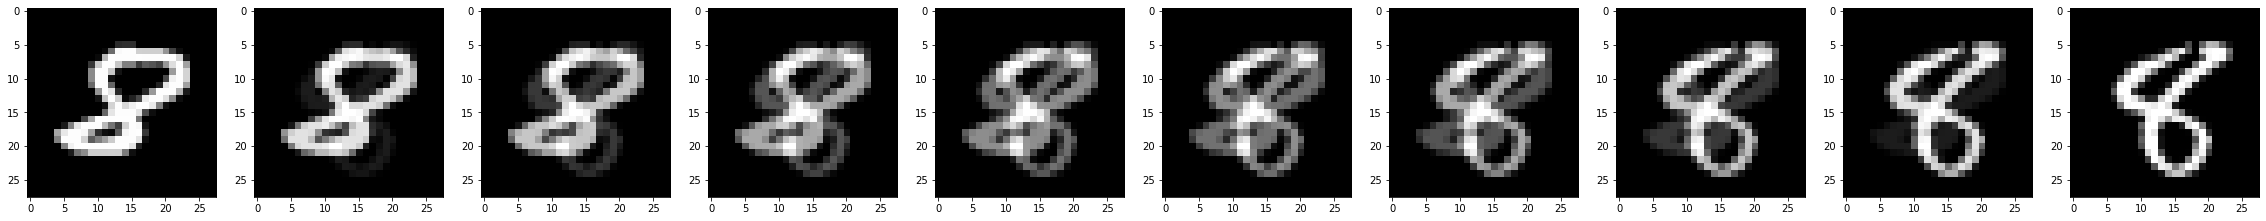

In [29]:
# Гомотопия между первыми двумя восьмерками

# 61 и 84 выбраны не случайно, под такими индексами в тестовых данных хранятся восьмерки

frm = dataset_test[61][0]
to = dataset_test[84][0]
plot_homotopy(frm, to)

Если наше латентное пространтсво корректное, мы нашли правильно параметаризованное латентное пространство, 
то небольшие сдвиги в этом пространстве должны давать разумные результаты: 

**Можно сказать то же самое, но завернуть это более витиевато:** Если же двигаться по кривой между кодами (и если многообразие кодов хорошо параметризовано), то декодер переведет эту кривую из пространства кодов, в кривую, не покидающую определяющее многообразие в пространстве объектов. То есть промежуточные объекты на кривой будут принадлежать генеральной совокупности.

In [30]:
conv_model.encoder(frm[None, :, :, :].to(DEVICE)).shape

torch.Size([1, 128])

128


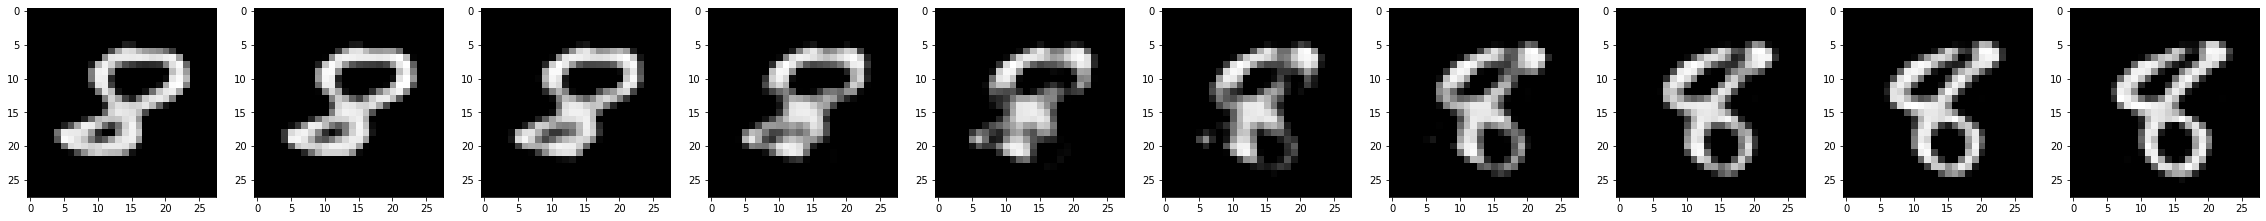

In [37]:
frm = dataset_test[61][0]
to = dataset_test[84][0]

with torch.no_grad():
    frm_enc = conv_model.encoder(frm[None, :, :, :].to(DEVICE))
    to_enc = conv_model.encoder(to[None, :, :, :].to(DEVICE))
    codes = torch.cat([frm_enc, to_enc])

plot_homotopy(codes[0], codes[1], n=10, decode=True)
# plot_homotopy(frm, to, n=10, decode=True)